<a href="https://colab.research.google.com/github/shubham19999/Mask_Detection/blob/master/Mask_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xmltodict

import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import torchvision 
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import xml.etree.ElementTree as ET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Unreal_AI/COVID-19/training/"

annotations  images  patched_annotations


In [ ]:
def getImageNames():
    image_names = []
    for dirname, _, filenames in os.walk('/content/drive/My Drive/Unreal_AI/COVID-19/training'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml' and (extension == '.jpg' or extension == 'jpeg'):
                image_names.append(filename)
    return image_names


def get_path(image_name):

  home_path = '/content/drive/My Drive/Unreal_AI/COVID-19/training/'
  image_path = home_path + 'images/' + image_name
    
  if image_name[-4:] == 'jpeg':
      label_name = image_name[:-5] + '.xml'
  else:
      label_name = image_name[:-4] + '.xml'
    
  label_path = home_path + 'annotations/' + label_name
        
  return  image_path, label_path

In [ ]:
def parse_xml(label_path):
  x = xmltodict.parse(open(label_path , 'rb'))
  item_list = x['annotation']['object']
    
    # when image has only one bounding box
  if not isinstance(item_list, list):
    item_list = [item_list]
        
  result = []
    
  for item in item_list:
      name = item['name']
      bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
      result.append((name, bndbox))
    
  image_names = x['annotation']['filename']
  image_path, label_path  = get_path(image_names)
  image = cv2.imread(f'{image_path}')
  #i1 = image.shape[0]
  #i2 = image.shape[1]
  #size = [int(i1), int(i2)]
  size = [1000, 1000]

  return result, size


def visualize_image(image_name, bndbox=True):
    
    
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'face_mask':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'face':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

In [ ]:
image_names = getImageNames()

In [ ]:
image_names[2337]

'41_Swimming_Swimmer_41_174.jpg'

In [ ]:
l = get_path(image_names[2337])[1]
l

'/content/drive/My Drive/Unreal_AI/COVID-19/training/annotations/41_Swimming_Swimmer_41_174.xml'

In [ ]:
 parse_xml(l)

KeyError: ignored

In [ ]:
len(image_names)

4393

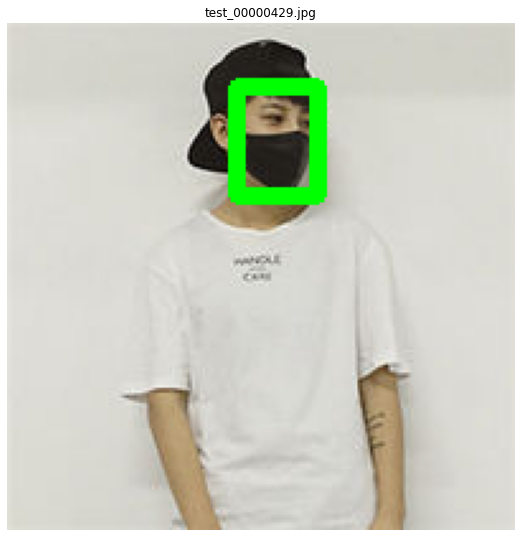

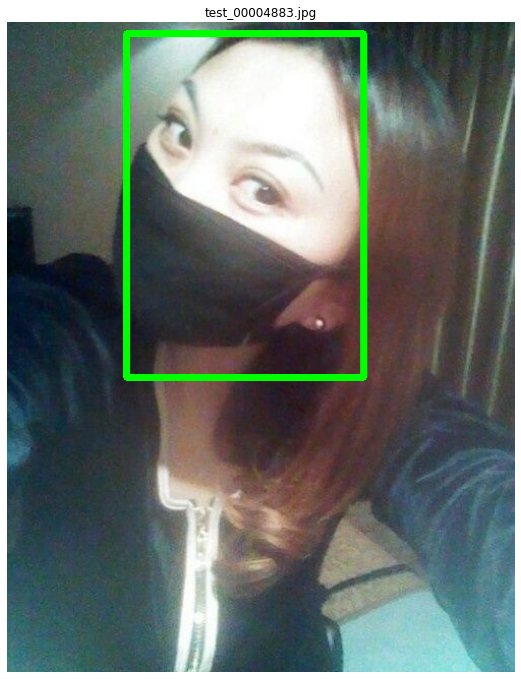

In [ ]:

for i in range(110,112):
    visualize_image(image_names[i])

In [ ]:
def cropImage(image_name):
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    labels, size = parse_xml(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "face_mask":
            label_num = 0
        elif name == "face":
            label_num = 1
        else:
            label_num = 2
      
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels
        

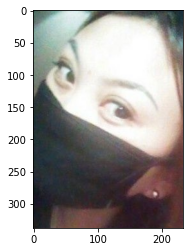

In [ ]:
a = cropImage(image_names[111])
a
plt.imshow(a[0][0])

In [ ]:
len(image_names)

4393

In [ ]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [ ]:
dir_name = 'train/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
#label_2_dir = dir_name + "2/"
models_dir = "models/"


createDirectory(dir_name)
createDirectory(label_0_dir)
createDirectory(label_1_dir)
#createDirectory(label_2_dir)
createDirectory(models_dir)

Directory train/ already exists.
Directory train/0/ already exists.
Directory train/1/ already exists.
Directory models/ already exists.


In [ ]:
label_0_counter = 0
label_1_counter = 0
#label_2_counter = 0

for i in range (0,2337):
  cropedImgLabels = cropImage(image_names[i])
  print(i)
    
  for cropedImgLabel in cropedImgLabels:
    label = cropedImgLabel[1]
    img = cropedImgLabel[0]
        
    if label == 0:
        croped_img_name = str(label_0_counter) + ".jpg"
        cv2.imwrite(label_0_dir + croped_img_name, img)
        label_0_counter += 1
    elif label == 1:
        croped_img_name = str(label_1_counter) + ".jpg"
        cv2.imwrite(label_1_dir + croped_img_name, img)
        label_1_counter += 1
        #else:
            #croped_img_name = str(label_2_counter) + ".jpg"
            #cv2.imwrite(label_2_dir + croped_img_name, img)
            #label_2_counter += 1

for i in range (2338,3404):
  cropedImgLabels = cropImage(image_names[i])
  print(i)
    
  for cropedImgLabel in cropedImgLabels:
    label = cropedImgLabel[1]
    img = cropedImgLabel[0]
        
    if label == 0:
        croped_img_name = str(label_0_counter) + ".jpg"
        cv2.imwrite(label_0_dir + croped_img_name, img)
        label_0_counter += 1
    elif label == 1:
        croped_img_name = str(label_1_counter) + ".jpg"
        cv2.imwrite(label_1_dir + croped_img_name, img)
        label_1_counter += 1



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyError: ignored

In [ ]:
for i in range (3405,4393):
  cropedImgLabels = cropImage(image_names[i])
  print(i)
    
  for cropedImgLabel in cropedImgLabels:
    label = cropedImgLabel[1]
    img = cropedImgLabel[0]
        
    if label == 0:
        croped_img_name = str(label_0_counter) + ".jpg"
        cv2.imwrite(label_0_dir + croped_img_name, img)
        label_0_counter += 1
    elif label == 1:
        croped_img_name = str(label_1_counter) + ".jpg"
        cv2.imwrite(label_1_dir + croped_img_name, img)
        label_1_counter += 1

3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604


In [ ]:
filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]
#onlyfiles_2 = [f for f in listdir(label_2_dir) if isfile(join(label_2_dir, f))]

In [ ]:
print("Total number of images: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))
#print("Number of images labeled 2: " + str(len(onlyfiles_2)))

Total number of images: 9538
Number of images labeled 0: 2234
Number of images labeled 1: 7304


In [ ]:
def getImageNamesval():
    image_names = []
    for dirname, _, filenames in os.walk('/content/drive/My Drive/Unreal_AI/COVID-19/validation'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml' and (extension == '.jpg' or extension == 'jpeg'):
                image_names.append(filename)
    return image_names

def get_path_val(image_name):

  home_path = '/content/drive/My Drive/Unreal_AI/COVID-19/validation/'
  image_path = home_path + 'images/' + image_name
    
  if image_name[-4:] == 'jpeg':
      label_name = image_name[:-5] + '.xml'
  else:
      label_name = image_name[:-4] + '.xml'
    
  label_path = home_path + 'annotations/' + label_name
        
  return  image_path, label_path

In [ ]:
def parse_xml_val(label_path):
  x = xmltodict.parse(open(label_path , 'rb'))
  item_list = x['annotation']['object']
    
    # when image has only one bounding box
  if not isinstance(item_list, list):
    item_list = [item_list]
        
  result = []
    
  for item in item_list:
      name = item['name']
      bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
      result.append((name, bndbox))
    
  image_names = x['annotation']['filename']
  image_path, label_path  = get_path_val(image_names)
  #image = cv2.imread(f'{image_path}')
  #i1 = image.shape[0]
  #i2 = image.shape[1]
  #size = [int(i1), int(i2)]
  size = [1000, 1000]

  return result, size


def visualize_image_val(image_name, bndbox=True):
    
    
    image_path, label_path = get_path_val(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml_val(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'face_mask':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'face':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

In [ ]:
image_names_val = getImageNamesval()

In [ ]:
len(image_names_val)

1585

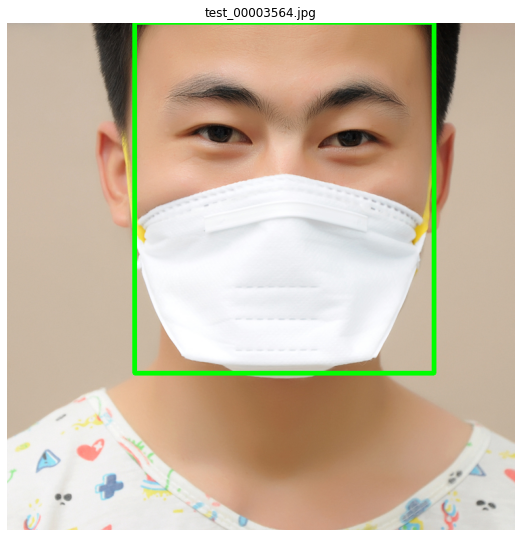

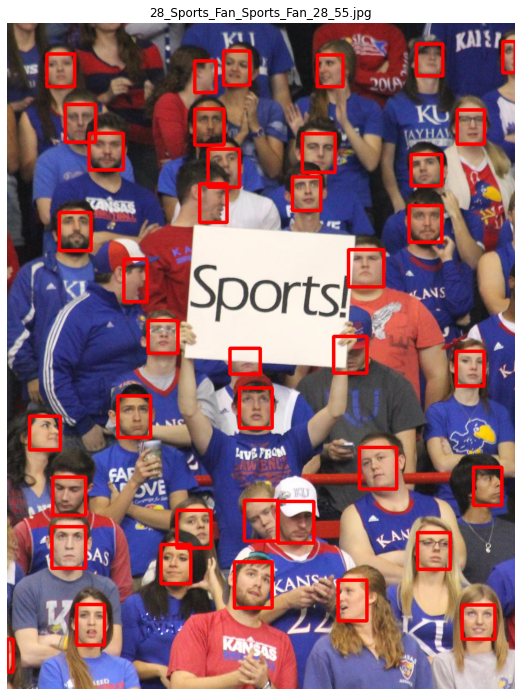

In [ ]:
for i in range(110,112):
    visualize_image_val(image_names_val[i])

In [ ]:
def cropImage_val(image_name):
    image_path, label_path = get_path_val(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    labels, size = parse_xml_val(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "face_mask":
            label_num = 0
        elif name == "face":
            label_num = 1
        else:
            label_num = 2
      
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels

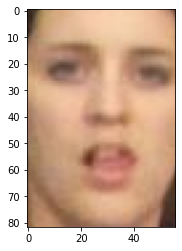

In [ ]:
a = cropImage_val(image_names_val[111])
a
plt.imshow(a[0][0])

In [ ]:
dir_name_val = 'val/'
label_0_dir_val = dir_name_val + "0/"
label_1_dir_val = dir_name_val + "1/"

createDirectory(dir_name_val)
createDirectory(label_0_dir_val)
createDirectory(label_1_dir_val)

Directory val/ already exists.
Directory val/0/ already exists.
Directory val/1/ already exists.


In [ ]:
label_0_counter = 0
label_1_counter = 0
#label_2_counter = 0

for i in range (0,1585):
  cropedImgLabels = cropImage_val(image_names_val[i])
  print(i)
    
  for cropedImgLabel in cropedImgLabels:
    label = cropedImgLabel[1]
    img = cropedImgLabel[0]
        
    if label == 0:
        croped_img_name = str(label_0_counter) + ".jpg"
        cv2.imwrite(label_0_dir_val + croped_img_name, img)
        label_0_counter += 1
    elif label == 1:
        croped_img_name = str(label_1_counter) + ".jpg"
        cv2.imwrite(label_1_dir_val + croped_img_name, img)
        label_1_counter += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
filenames_label_0 = [f for f in listdir(label_0_dir_val) if isfile(join(label_0_dir_val, f))]
filenames_label_1 = [f for f in listdir(label_1_dir_val) if isfile(join(label_1_dir_val, f))]

In [ ]:
print("Total number of images: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))

Total number of images: 3133
Number of images labeled 0: 801
Number of images labeled 1: 2332


In [ ]:
def getImageNamestest():
    image_names = []
    for dirname, _, filenames in os.walk('/content/drive/My Drive/Unreal_AI/COVID-19/example'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension == '.png':
                image_names.append(filename)
    return image_names

def get_path_test(image_name):

  home_path = '/content/drive/My Drive/Unreal_AI/COVID-19/'
  image_path = home_path + 'example/' + image_name
    
  if image_name[-4:] == 'jpeg':
      label_name = image_name[:-5] + '.xml'
  else:
      label_name = image_name[:-4] + '.xml'
    
  label_path = home_path + 'example/' + label_name
        
  return  image_path, label_path

In [ ]:
def parse_xml_test(label_path):
  x = xmltodict.parse(open(label_path , 'rb'))
  item_list = x['annotation']['object']
    
    # when image has only one bounding box
  if not isinstance(item_list, list):
    item_list = [item_list]
        
  result = []
    
  for item in item_list:
      name = item['name']
      bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
      result.append((name, bndbox))
    
  image_names = x['annotation']['filename']
  image_path, label_path  = get_path_test(image_names)
  #image = cv2.imread(f'{image_path}')
  #i1 = image.shape[0]
  #i2 = image.shape[1]
  #size = [int(i1), int(i2)]
  size = [1000, 1000]

  return result, size


def visualize_image_test(image_name, bndbox=True):
    
    
    image_path, label_path = get_path_test(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml_test(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'face_mask':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'face':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

In [ ]:
image_names_test = getImageNamestest()

In [ ]:
len(image_names_test)

12

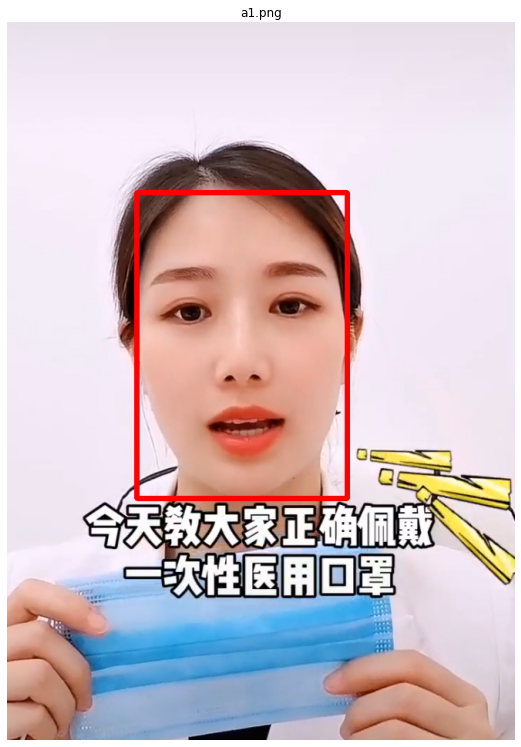

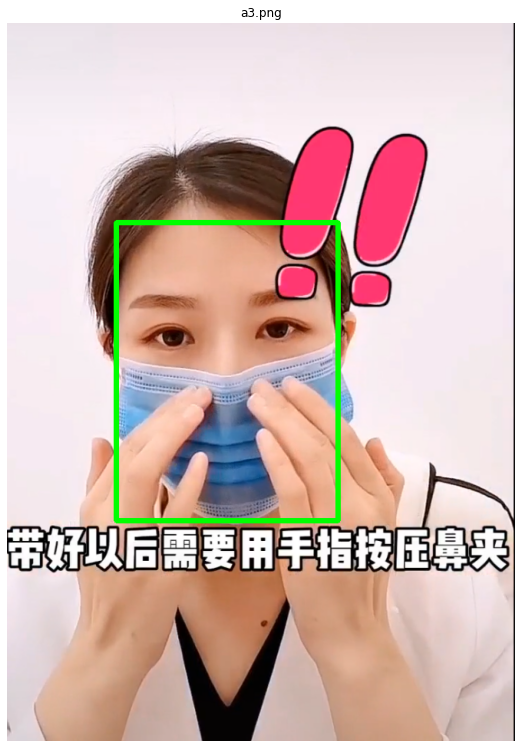

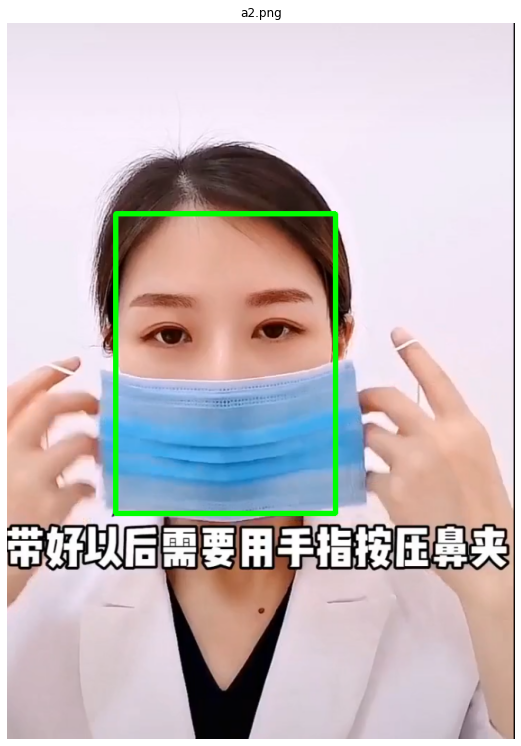

In [ ]:
for i in range(3):
    visualize_image_test(image_names_test[i])

In [ ]:
def cropImage_test(image_name):
    image_path, label_path = get_path_test(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    labels, size = parse_xml_test(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "face_mask":
            label_num = 0
        elif name == "face":
            label_num = 1
        else:
            label_num = 2
      
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels

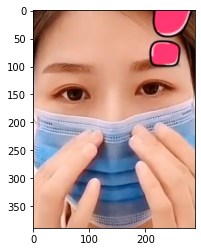

In [ ]:
a = cropImage_test(image_names_test[1])
a
plt.imshow(a[0][0])

In [ ]:
dir_name_test = 'test/'
label_0_dir_test = dir_name_test + "0/"
label_1_dir_test = dir_name_test + "1/"

createDirectory(dir_name_test)
createDirectory(label_0_dir_test)
createDirectory(label_1_dir_test)

In [ ]:
label_0_counter = 0
label_1_counter = 0
#label_2_counter = 0

for i in range (0,12):
  cropedImgLabels = cropImage_test(image_names_test[i])
  print(i)
    
  for cropedImgLabel in cropedImgLabels:
    label = cropedImgLabel[1]
    img = cropedImgLabel[0]
        
    if label == 0:
        croped_img_name = str(label_0_counter) + ".jpg"
        cv2.imwrite(label_0_dir_test + croped_img_name, img)
        label_0_counter += 1
    elif label == 1:
        croped_img_name = str(label_1_counter) + ".jpg"
        cv2.imwrite(label_1_dir_test + croped_img_name, img)
        label_1_counter += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
filenames_label_0 = [f for f in listdir(label_0_dir_test) if isfile(join(label_0_dir_test, f))]
filenames_label_1 = [f for f in listdir(label_1_dir_test) if isfile(join(label_1_dir_test, f))]

In [ ]:
print("Total number of images: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))

Total number of images: 12
Number of images labeled 0: 8
Number of images labeled 1: 4


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:

for layer, param in model.named_parameters():
    
    if 'layer4' not in layer:
        param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.2),
                                 torch.nn.Linear(512, 2),
                                 torch.nn.LogSoftmax(dim=1))

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [ ]:
train_dataset = datasets.ImageFolder(dir_name, transform = train_transforms)
val_dataset = datasets.ImageFolder(dir_name_val, transform = train_transforms)
test_dataset = datasets.ImageFolder(dir_name_test, transform = train_transforms)

print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(val_dataset))
print('Test set size: ', len(test_dataset))

Train set size:  9538
Validation set size:  3133
Test set size:  12


In [ ]:
BATCH_SIZE = 50

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
LEARNING_RATE = 0.01

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
#model.cuda()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
total_epoch = 10

best_epoch = 0
training_losses = []
val_losses = []


for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    
    for X, y in train_loader:
        
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append(epoch_train_loss)
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in val_loader:
            
            X, y = X.cuda(), y.cuda()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            _, maximum = torch.max(result.data, 1)
            total += y.size(0)
            correct += (maximum == y).sum().item()
            
    val_losses.append(epoch_val_loss)
    accuracy = correct/total
    print("EPOCH:", epoch, ", Training Loss:", epoch_train_loss, ", Validation Loss:", epoch_val_loss, ", Accuracy: ", accuracy)
    
    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
        print("Model saved")

EPOCH: 0 , Training Loss: 10.388895080073496 , Validation Loss: 43.80162376660155 , Accuracy:  0.9616980529843601
Model saved
EPOCH: 1 , Training Loss: 2.4547247279282374 , Validation Loss: 46.26813630797551 , Accuracy:  0.967124162144909
EPOCH: 2 , Training Loss: 47.85291510025854 , Validation Loss: 37.14976472040871 , Accuracy:  0.96488988190233
Model saved
EPOCH: 3 , Training Loss: 16.660816996591166 , Validation Loss: 13.517515355721116 , Accuracy:  0.969996808171082
Model saved
EPOCH: 4 , Training Loss: 7.6691986754885875 , Validation Loss: 10.194938610191457 , Accuracy:  0.970954356846473
Model saved
EPOCH: 5 , Training Loss: 3.7859026216856364 , Validation Loss: 13.698982244124636 , Accuracy:  0.974784551548037
EPOCH: 6 , Training Loss: 1.9117434772306297 , Validation Loss: 16.248676061513834 , Accuracy:  0.9623364187679541
EPOCH: 7 , Training Loss: 1.7898187703267467 , Validation Loss: 21.539759913853686 , Accuracy:  0.971911905521864
EPOCH: 8 , Training Loss: 0.679803816021205

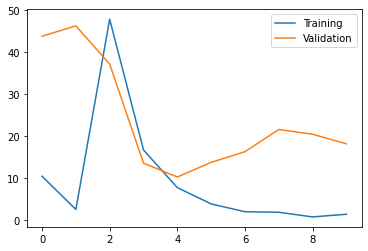

In [ ]:
plt.plot(range(total_epoch), training_losses, label='Training')
plt.plot(range(total_epoch), val_losses, label='Validation')
plt.legend()      

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = models_dir + str(best_epoch) + ".pth"
loaded_model = load_checkpoint(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

In [ ]:
correct = 0
total = 0
    
with torch.no_grad():
    for X, y in test_loader:

        X, y = X.cuda(), y.cuda()

        result = loaded_model(X)
        _, maximum = torch.max(result.data, 1)
        total += y.size(0)
        correct += (maximum == y).sum().item()

accuracy = correct/total

print("\n")
print("------------")
print("Accuracy: " + str(accuracy))
print("------------")
print("\n")



------------
Accuracy: 1.0
------------




In [ ]:
result

tensor([[-9.0599e-06, -1.1612e+01],
        [ 0.0000e+00, -1.7849e+01],
        [-1.5514e+01,  0.0000e+00],
        [-7.6294e-06, -1.1807e+01],
        [-1.4080e+01, -4.7684e-07],
        [ 0.0000e+00, -1.8328e+01],
        [-9.1822e+00, -1.0300e-04],
        [-1.2490e-02, -4.3891e+00],
        [ 0.0000e+00, -1.5619e+01],
        [-2.3902e+01,  0.0000e+00],
        [-1.4305e-06, -1.3308e+01],
        [-7.4291e-04, -7.2053e+00]], device='cuda:0')